# PCA on STL 10

This notebook was made in fulfillment for the graduate course EE298: Foundations of Machine Learning

- Author: Joshua A. Javier
- Date: January 13, 2021
- Liscence: MIT

System Specifications used:
- CPU: Ryzen 2600
- RAM: 16GB (11 Gb Usable)
- OS: Manjaro Kernel 5.9

Python Environment:
- Python 3.7
- Tensorflow 2.4 (No Cuda)
- Sklearn 0.24
- Numpy 1.19.5

## Import Libraries

In [1]:
from __future__ import print_function
import tensorflow_datasets as tfds
from scipy import linalg
import numpy as np
import sys
import os, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt
import math

## Data Loader

Data is loaded from disk due to very slow download speed when loading directly from source during development. Files are extracted using the utility functions defined below and transformed into a TF Dataset object for further processing. However if direct download is preferred one can simply use the `tfds.load('stl10')` from the tensorflow_datasets library. 

**NOTE**: The unlabeled dataset has 100K files from source, the unlabeled set used in this notebook only contains 10K images per requirement.

### Utility functions

Function to extract the images from the compressed file.
Modified from reference: https://github.com/mttk/STL10



**NOTE** Directory tree must be as follows
```
Current Directory tree
|
|---datasets
|    |---stl10_binary
|         |-class_names.txt
|         |-fold_indices.txt
|         |-train_X.bin
|         |-test_X.bin
|         |-unlabeled_X.bin
|         |-train_y.bin
|         |-test_y.bin
|
|---Javier_EE298_STL10.ipynb
```

In [2]:
if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

try:
    from imageio import imsave
except:
    from scipy.misc import imsave

print(sys.version_info) 

# Image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# Size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# Path to the directory with the data
DATA_DIR = './datasets'

# Url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# Path to the binary files with image data
TRAIN_DATA_PATH = './datasets/stl10_binary/train_X.bin'
TEST_DATA_PATH = './datasets/stl10_binary/test_X.bin'
UNLABELED_PATH = './datasets/stl10_binary/unlabeled_X.bin'


# Path to the binary files with labels
TRAIN_LABEL_PATH = './datasets/stl10_binary/train_y.bin'
TEST_LABEL_PATH = './datasets/stl10_binary/test_y.bin'


def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

def save_image(image, name):
    imsave("%s.png" % name, image, format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def save_images(images, labels, split='train'):
    print("Saving images to disk")
    split_types = ['train', 'test', 'unlabeled10k']
    if split not in split_types:
        raise ValueError(f"Invalid split type. Expected one of: {split_types}")
    
    
    img_dir = f'/stl10/img/{split}/'
    
    i = 0
    for image in images:
        label = labels[i]
        directory = DATA_DIR + img_dir + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1

def train_main():
    # download data if needed
    download_and_extract()

    # test to check if the image is read correctly
    with open(TRAIN_DATA_PATH) as f:
        image = read_single_image(f)
        plot_image(image)

    # test to check if the whole dataset is read correctly
    images = read_all_images(TRAIN_DATA_PATH)
    print(images.shape)

    labels = read_labels(TRAIN_LABEL_PATH)
    print(labels.shape)

    # save images to disk
    save_images(images, labels, split='train')

def test_main():
    # download data if needed
    download_and_extract()

    # test to check if the image is read correctly
    with open(TEST_DATA_PATH) as f:
        image = read_single_image(f)
        plot_image(image)

    # test to check if the whole dataset is read correctly
    images = read_all_images(TEST_DATA_PATH)
    print(images.shape)

    labels = read_labels(TEST_LABEL_PATH)
    print(labels.shape)

    # save images to disk
    save_images(images, labels, split='test')
    
def unlabeled_main():
    # download data if needed
    download_and_extract()

    # test to check if the image is read correctly
    with open(UNLABELED_PATH) as f:
        image = read_single_image(f)
        plot_image(image)

    # test to check if the whole dataset is read correctly
    images = read_all_images(UNLABELED_PATH)
    images = images[:10000]
    print(images.shape)
    
    # Since its unlabelled, an arbitrary label of 11 was used
    labels = np.full((images.shape[0],), 11, dtype=int)
    print(labels.shape)

    # save images to disk
    save_images(images, labels, split='unlabeled10k')

sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)


### Extract images to folder

Do not run if images are already extracted else there will be duplicate images in the datasets

In [1]:
# TrainData
train_main()
# Test Data
test_main()
# 10K Unlabeled Data
unlabeled_main()

NameError: name 'train_main' is not defined

## Generate Datasets

### Locally

In [2]:
# Use the tensorflow_datasets to build the dataset
image_dir = 'D:/dev/jupyter_notebooks/datasets/stl10/img/' # Replace with respective path
builder = tfds.ImageFolder(image_dir)
# print(builder.info)  # num examples, labels etc

In [3]:
# Load local data as tensorflow dataset object
ds_train = builder.as_dataset(split='train', batch_size=-1,
           as_supervised=True, shuffle_files=True)
ds_test = builder.as_dataset(split='test', batch_size=-1,
          as_supervised=True, shuffle_files=True)
ds_unlabled = builder.as_dataset(split='unlabeled10k', batch_size=-1,
              as_supervised=True, shuffle_files=True)

In [4]:
# Convert to numpy arrays
tr_set, tr_label = tfds.as_numpy(ds_train)
test_set, test_label = tfds.as_numpy(ds_test)
unlabeled_set, mock_label = tfds.as_numpy(ds_unlabled)

In [5]:
# Scale
norm_train = np.float32(tr_set)/ 255.
norm_test = np.float32(test_set)/ 255.
norm_unlabeled = np.float32(unlabeled_set)/ 255.

In [6]:
# Reshape
train_reshape = np.reshape(norm_train,(norm_train.shape[0], -1))
test_reshape = np.reshape(norm_test,(norm_test.shape[0], -1))
unlabeled_reshape = np.reshape(norm_unlabeled,(norm_unlabeled.shape[0], -1))

### Show sample images

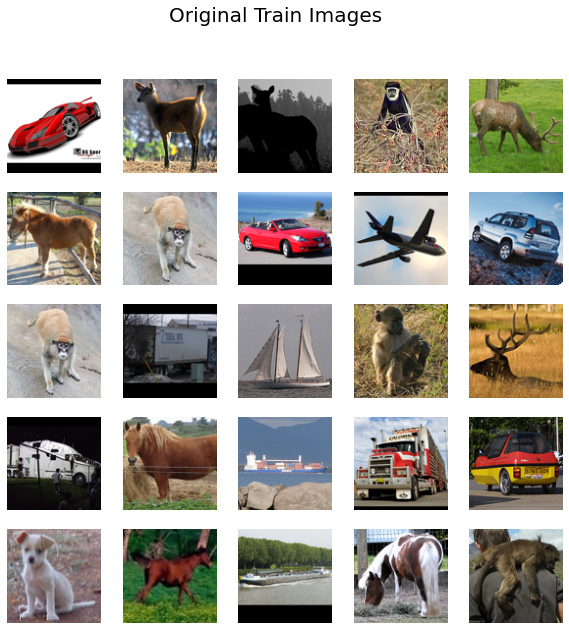

In [7]:
import math
n_images = 100
indexes = np.random.randint(0, norm_train.shape[0], size=n_images)
images = norm_train[indexes]

# util function for displaying images in a grid
def plot_images(images, title, n_images=25):
    plt.figure(figsize=(10,10))
    plt.suptitle(title, fontsize=20)
    side = int(math.sqrt(n_images))
    for i in range(n_images):
        plt.subplot(side, side, i + 1)
        image = images[i]
        plt.imshow(image.astype('float32'), cmap='gray')
        plt.axis('off')

    plt.show()
    plt.close('all')
    
title = "Original Train Images"
plot_images(images, title=title)
orig_shape = images.shape

## Data Preparation

In [8]:
from sklearn.preprocessing import StandardScaler

# Assign data and labels
train_raw = train_reshape
test_raw = test_reshape
unlabeled_raw = unlabeled_reshape

train_y = tr_label
test_y = test_label
unlabeled_y = mock_label

In [9]:
# Standardize Data
std_slc = StandardScaler()
# Train
std_slc.fit(train_raw)
train_std = std_slc.transform(train_raw)
# Test
std_slc.fit(test_raw)
test_std = std_slc.transform(test_raw)
# Unlabeled
std_slc.fit(unlabeled_raw)
unlabeled_std = std_slc.transform(unlabeled_raw)

## PCA using Sklearn

In [10]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import time

### PCA using different component dimensions

In [11]:
# Define function to get MSE per input dimension
def get_mse(centered_data, components):
    '''
    Calculate the mean squared error per `n` component
    
    Parameters:
    
    centerd_data(numpy array) - Array of [n_samples, n_features] with points centered to the mean.
    components(list) - List of number of target components to apply to the PCA algorithm.
    
    Returns:
    mse_list(list) - List of mean-squared errors calculated using the original data
                     and the reduced data    
    '''
    mse_list = []
    for n in components:
        pca = PCA(n_components=n)
        principalComponents = pca.fit_transform(centered_data)
        recon = pca.inverse_transform(principalComponents)
        mse = mean_squared_error(centered_data, recon,squared=True)
        mse_list.append(mse)
        print(f"MSE: {mse} with {n} components")
    return mse_list


In [15]:
# Do PCA on training set with 7 different components
components = [32, 64, 256, 512, 1028, 2046, 4098]
# Time execution - 1695 on current system
start = time.process_time()
mse_list = get_mse(unlabeled_std, components)
print(time.process_time() - start)


MSE: 0.31074729561805725 with 32 components
MSE: 0.2437043935060501 with 64 components
MSE: 0.13562709093093872 with 256 components
MSE: 0.0928194522857666 with 512 components
MSE: 0.056838784366846085 with 1028 components
MSE: 0.027739711105823517 with 2046 components
MSE: 0.008151400834321976 with 4098 components
2834.234375


### Single PCA pass

In [12]:
# Single PCA retaining 95% of the variance
var_to_retain = 0.95
pca_ideal = PCA(var_to_retain)
ideal_pc = pca_ideal.fit_transform(unlabeled_std)
recon = pca_ideal.inverse_transform(ideal_pc)
mse = mean_squared_error(unlabeled_std, recon,squared=True)
print(f"MSE: {mse} retaining {var_to_retain} variance")
print(f"Ideal number of components retaining 95% of variance is {ideal_pc.shape[1]}")

MSE: 0.04999341815710068 retaining 0.95 variance
Ideal number of components retaining 95% of variance is 1174


In [13]:
# Single PCA pass retaining 80% of the variance
n = 120
pca_n = PCA(n_components=n)
principalComponents_n = pca_n.fit_transform(unlabeled_std)
recon_n = pca_n.inverse_transform(principalComponents_n)
mse = mean_squared_error(unlabeled_std, recon_n,squared=True)
print(f"MSE: {mse} with {n} components")
print(f"Total variance with {n} components: {pca_n.explained_variance_ratio_.sum()}")

MSE: 0.1905021369457245 with 120 components
Total variance with 120 components: 0.8094977736473083


## PCA from scratch

Due to hardaware limitations, limited processing power and the size of the dataset to be processed, instead of calculating the covariance matrix and eigendecomposition to reduce dimensions, SVD was used instead**. This is due to SVD utilizing more threads where eigendecomposition of both numpy and sklearn only uses a single thread. SVD produces the required eigenvalues and eigenvectors equal to the ones produced  by numpy and sklearn eigendecomposition methods. However, the implementation presented in the lecture was tested and implemented in CIFAR10 as proof of learning. Reference: https://github.com/the-black-viper/ml/tree/main/EE298

*I tried to run the algorithm presented from the lecture notes on the target dataset however after more than 12 hours I still could not get results where I am hitting 99% on my CPU and Memory leading to my machine freezing.

#### Define functions

In [12]:
# Use a utility function for sign correction and reproducibility of results
from sklearn.utils.extmath import svd_flip


In [13]:
def manual_pca(X, n_components):
    '''
    PCA Implementation using single value decomposition
    
    Parameters:
    X(numpy array) - Array of [n_samples, n_features] to reduce.
    n_components(int) - Number of components
    
    Returns:
    U(numpy array) - Eigenvectors of XX.T
    components_(numpy array) - Reduced dataset containing the principal components
    '''
    # Center data
    mean_ = np.mean(X, axis=0)
    X -= mean_

    U, S, Vt = linalg.svd(X, full_matrices=False)
    
    # Sign correction
    U, Vt = svd_flip(U, Vt)
    components = Vt
    components_ = components[:n_components]
    U = U[:, :n_components]
    U *= S[:n_components]

    return (U, components_)

In [14]:
def mse(x, reduced_x, components):
    '''
    Calculate and return the mean squared error of of two datasets
    
    Parameters:
    x(numpy array) - Original dataset with [n_samples, d_features]
    reduced_x(numpy array) - Reduced dataset [n_samples, m_features]
    
    Returns:
    error - mean squared error between the two input datasets
    '''
    # Inverser Transform
    recon = np.dot(reduced_x, components) + np.mean(x)
    # Get MSE
    error = mean_squared_error(x, recon,squared=True)

    return error

In [15]:
# Define function to get MSE per input dimension
def get_mse_manual(centered_data, components):
    '''
    Parameters:
    
    centerd_data(numpy array) - Array of [n_samples, n_features] 
                                with points centered to the mean.
    components(list) - List of number of target
                       components to apply to the PCA algorithm.
    
    Returns:
    mse_list(list) - List of mean-squared errors calculated using the original data
                     and the reduced data    
    '''
    mse_list = []
    for n in components:
        principalComponents, components_ = manual_pca(centered_data, n)
        error = mse(centered_data, principalComponents, components_)
        mse_list.append(error)
        print(f"MSE: {error} with {n} components")
    return mse_list

### PCA using different component dimensions

In [16]:
components = [32, 64, 256, 512, 1028, 2046, 4098]
# Time execution
import time
start = time.process_time()
manual_mse_list = get_mse_manual(unlabeled_std, components)
print(time.process_time() - start)

MSE: 0.310735285282135 with 32 components
MSE: 0.24363937973976135 with 64 components
MSE: 0.13536173105239868 with 256 components
MSE: 0.09256523102521896 with 512 components
MSE: 0.05616787075996399 with 1028 components
MSE: 0.027308830991387367 with 2046 components
MSE: 0.007988189347088337 with 4098 components
18767.939506027


#### Single pass with 1174 components

In [19]:
n = 1174
pca_custom, components_custom = manual_pca(unlabeled_std, n)
error = mse(unlabeled_std, pca_custom, components_custom)
print(f"MSE: {error} with {n} components")

MSE: 0.04999341815710068 with 1174 components


## Plot MSE vs Dimensions

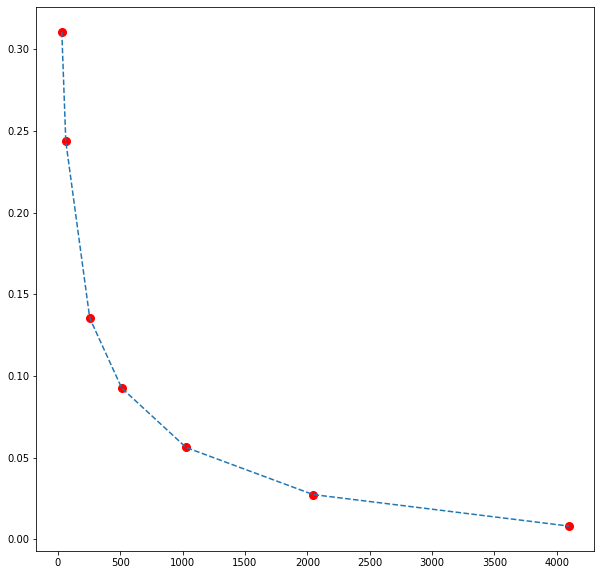

In [17]:
plt.figure(figsize=(10,10))
plt.plot(components, manual_mse_list, 'ro', markersize=8)
plt.plot(components, manual_mse_list, '--')

From the plot, the 'elbow' is around at 1028 components, thus it will be chosen as the minimum dimensions to get a balance between the execution time and data loss. From the list of components this is also the nearest to n=1174 which retains 95% of the variance of the dataset.

## Reconstruct Images using the reduced data

In [13]:
# Reshape data
images_ = recon.reshape((-1,96,96,3))

In [15]:
n_images = 100
n = 1174 # Ideal number of components retaining 95% variance
indexes = np.random.randint(0, n, size=n_images)
raw_images = images_[indexes]


100


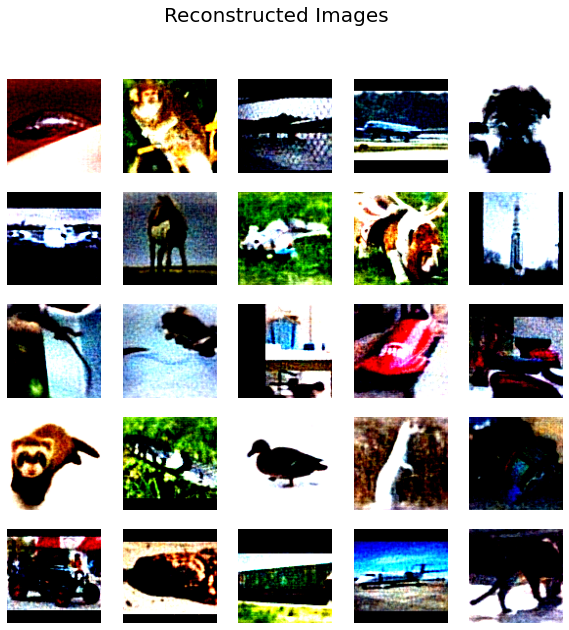

In [17]:
title = "Reconstructed Images"
images = np.clip(raw_images,0,255)
print(len(images))
plot_images(images, title=title)
orig_shape = images.shape

# GMM Feasibility

## GMM SKlearn implementation

In [18]:
from sklearn.mixture import GaussianMixture as GMM

# Use PCA with 1174 features/dimensions since this was determined
# to be the balance between retaining most features and efficiency
gmm_train = ideal_pc
gmm_test = test_raw[:,:1174] # Get the equivalent number of features from the test dataset

In [19]:
# Define the model and test using 10 clusters and use the reduced unlabeled set
n = 10
gmm_model = GMM(n_components=n, covariance_type='full')
gmm = gmm_model.fit(gmm_train)

In [20]:
# Check if converged
print(gmm.converged_)

True


### Label Prediction using Test Set

In [21]:
# Get a list of predicted 'labels' for each sample in the test dataset
test_predicts = gmm.predict(gmm_test)

In [22]:
# Test "accuracy" of the predicted clusters
correct = 0;
for i in range(len(test_predicts)):
    if test_y[i] == test_predicts[i]:
        correct += 1
percentage = 100*correct/float(len(test_predicts))
print(f"{percentage}% Accuracy")


8.8625% Accuracy


## GMM from Scratch

In [23]:
from scipy.stats import multivariate_normal
from scipy.stats import mode
from sklearn.metrics import confusion_matrix

### GMM Custom Class

In [24]:
class GMM:
    """
    Gaussian Mixture Model using EM Algorithm.

    Parameters:
    n_components(int) - Number of clusters/mixture components to fit the data
    n_iters(int) - Maximum number of iterations to run the algorithm
    tol(float) - Tolerance to compare the values when updating the parameters.
    seed(int/default=42) - Seed / random state used to initialize the parameters.
    """

    def __init__(self, n_components, n_iters, tol, seed=42):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed
        self.cluster_names = [index for index in range(self.n_components)]
        
    def fit(self, X):

        # Define responsibility matrix
        n_row, n_col = X.shape
        self.resp = np.zeros((n_row, self.n_components))

        # Initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(n_row, self.n_components, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components)
        
        # Since each row is a sample and colums are features set rowvar=False
        shape = self.n_components, n_col, n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False))

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      

        for i in range(self.n_iters):
            log_likelihood_new = self._do_estep(X)
            self._do_mstep(X)
            
            # Once the threshold is reached the algorithm is deemed converged
            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                break
  
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)

        return self

    def _do_estep(self, X):
        """
        E-step: compute responsibilities,
        update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j,
        to compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf
        """
        self._compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))

        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return log_likelihood

    def _compute_log_likelihood(self, X):
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood

        return self

    def _do_mstep(self, X):
        """M-step, update parameters"""

        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis = 0)
        
        # weights
        self.weights = resp_weights / X.shape[0]

        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self
    
    
    def _probabilities(self, X):
        '''
        Get the probabilities for each sample to belong in a cluster k
        '''
        n_row, n_cols = X.shape
        self.resp_pred = np.zeros((n_row, self.n_components))
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp_pred[:, k] = prior * likelihood
        
        denominator = self.resp_pred.sum(axis=1)[:, np.newaxis]
        weights = self.resp_pred/denominator
        return weights
    
    def predict(self, X):
        '''
        Get the class/cluster label from the index of the 
        highest probability
        '''
        probs = self._probabilities(X)
        cluster_preds = np.argmax(probs, axis=1)
        return cluster_preds

### Plot functions

In [25]:
def plot_contours(data, means, covs, title):
    """Visualize the gaussian components over the data"""
    
    fig = plt.figure()
    gs = fig.add_gridspec(8,2)
    ax1 = fig.add_subplot(gs[0:3, 0])
    ax2 = fig.add_subplot(gs[0:3, 1])
    ax3 = fig.add_subplot(gs[4:, :])
    ax1.plot(data[:, 0], data[:, 1], 'ko', alpha=0.1)
    ax3.plot(data[:, 0], data[:, 1], 'ko', alpha=0.1)
    delta = 0.0025
    k = means.shape[0]
    x = np.arange(0.0, 1.2, delta)
    y = np.arange(0.0, 1.2, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
    col = ['green', 'red', 'indigo', 'coral', 'chocolate', 'gold', 'maroon', 'skyblue', 'purple', 'silver']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        ax2.contour(x_grid, y_grid, z_grid, colors = col[i])
        ax3.contour(x_grid, y_grid, z_grid, colors = col[i])
    ax3.set_title(title)
    plt.tight_layout()

### GMM Custom Implementation

In [29]:
# Scale data to fit
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scale = scaler.fit_transform(gmm_train)
test_scale = scaler.fit_transform(gmm_test)

# Get the first two components 
trunc_test = test_scale[:,:2]
trunc_train = train_scale[:,:2]

In [30]:
# Fit using the custom GMM
gmm_mk3 = GMM(n_components = 10, n_iters = 1, tol = 1e-4, seed = 4)
gmm_mk3.fit(trunc_train)

### Label Prediction using Test set

In [31]:
# Predict labels on test dataset
preds = gmm_mk3.predict(trunc_test)

In [33]:
correct = 0;
for i in range(len(preds)):
    if test_y[i] == preds[i]:
        correct += 1
percentage = 100*correct/float(len(preds))
print(f"{percentage}% Accuracy")

9.3625% Accuracy


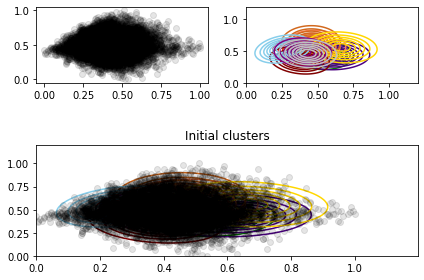

In [35]:
# Plot
plot_contours(trunc_train, gmm_mk3.means, gmm_mk3.covs, 'Initial clusters')

## Can we fit a 10-component GMM on the unlabeled dataset 𝒛 code vectors from PCA?

From the plot above, the contour lines represent the probability density of the cluster predictions and the circles represent the data points. Intuitively this means that the farther away from the center of the ellipse the lower the probability of a data point to belong to that particular cluster. 

The densely packed datapoints can also be observed and the resulting overlapping contour lines. This can be interpretted as the data points with respect to the selected components ( In this case is the first and the second ) are not well separated. 

From the initial and original data plotted, GMM _can_ be used. However it isn't ideal in this particular dataset since each feature(pixel) in each of the class does not have enough difference and therefore have multiple overlaps as shown in the graphs.

From the GMM, it can be seen that GMM in a way clustered some data however the problem persists that many of the data points overlap with one another as seen with overlapping contours

Although the data used to fit the model represents 80% of the original data, the ones present used in the plot only represent around 18% where only the first two principal components were used. However it can easily be checked that by plotting for every feature, the problem of having too much of an overlap between data points is still observed.

## Can we use the GMM and labeled train set to assign labels to the 10 clusters in GMM?

The results obtained in 2.1.1 and 2.2.4 with only around $\pm$ 10 % accuracy can be explained by two factors:

- In 2.1.1 the algorithm using the library implements arbirarily assigning labels to the clusters. It is not assured that the labels will match the true labels ie. Cluster Label 0 != Class Label 0.
- For both results the nature of the dataset being not well separated also adds to this low accuracy as explained in 2.3. This implies that multiple data points have relatively similar probabilities to belong in each cluster. The algorithm implemented did not have any tolerance to the difference between probabilities. Intuitively a data point with probability of 0.44 for cluster 0 and 0.45 for cluster 1 can belong in either clusters and the algorithm does not account for this small difference as it only choses the one with higher value.


## Can we build an STL generative model using unlabeled dataset  PCA 𝒛 code vectors and GMM?

### Generate new images from the generative GMM model

In [36]:
# Generate 100 new data points from the GMM model
data_new = gmm_model.sample(100)

# Using inverse transform the data is now 'returned' to the
# initial order which can be used for visualization
new_data = pca_ideal.inverse_transform(data_new[0])

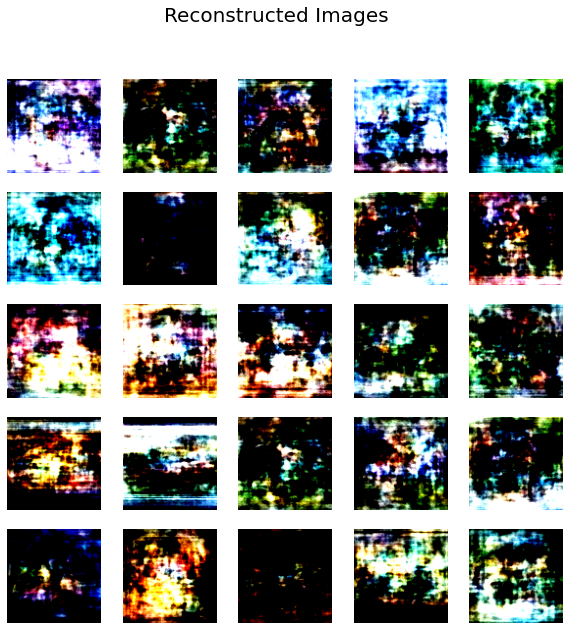

In [37]:
# Reshape data
images_ = new_data.reshape((-1,96,96,3))
n_images = 100
indexes = np.random.randint(0, 100, size=n_images)
raw_images = images_[indexes]

title = "Reconstructed Images"
images = np.clip(raw_images,0,255)
# print(len(images))
plot_images(images, title=title)
orig_shape = images.shape

From the reconstructed images above generated from new data genearted using the GMM model. With the limited data done in this experiment, it is shown that an STL generative model(with the parameters used) is not an accurate model. However, this can be improved using different parameters and possibly increasing the number of features used.

# References

https://www.tensorflow.org/datasets/overview
https://medium.com/swlh/principal-component-analysis-from-scratch-in-python-2f139c6420c9
https://towardsdatascience.com/pca-and-svd-explained-with-numpy-5d13b0d2a4d8
https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
https://www.kaggle.com/bburns/iris-exploration-pca-k-means-and-gmm-clustering
https://ethen8181.github.io/machine-learning/clustering/GMM/GMM.html#Reference